In [1]:
!cat ../bin/ppnet-local-analysis

##### MODEL AND DATA LOADING
import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import re

import os
import copy

from helpers import makedir, find_high_activation_crop
import model
import push
import train_and_test as tnt
import save
from log import create_logger
from preprocess import mean, std, preprocess_input_function, undo_preprocess_input_function

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('-gpuid', nargs=1, type=str, default='0')
parser.add_argument('-modeldir', nargs=1, type=str)
parser.add_argument('-model', nargs=1, type=str)
parser.add_argument('-imgdir', nargs=1, type=str)
parser.add_argument('-img', nargs=1, type=str)
parser.add_argument('-imgclass', nargs=1, type=int, default=-1)
args = parser.parse_args()

os.environ['CUDA_VISIBLE_DEVICES'] = args.gpuid

In [2]:
from IPython.display import display
import PIL.Image
import PIL.ImageDraw
import cv2
import numpy
import torch
import torchvision.transforms
import toyplot

import ppnet.helpers
import ppnet.preprocess

In [3]:
model = torch.load("../saved_models/vgg19/006/50_19push0.7546.pth", map_location="cpu")
prototypes = numpy.load("../saved_models/vgg19/006/img/epoch-50/bb50.npy")

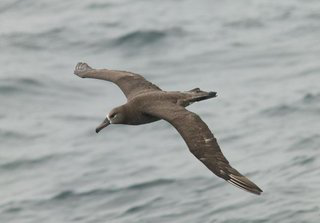

In [4]:
test_image = PIL.Image.open("../testing/Black_Footed_Albatross_0001_796111.jpg")
test_image

In [5]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize((model.img_size, model.img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=ppnet.preprocess.mean, std=ppnet.preprocess.std),
    ])

x = preprocess(test_image).unsqueeze(0)

In [6]:
logits, prototype_distances = model(x)
prototype_similarities = model.distance_2_similarity(prototype_distances)
prototype_similarities, prototype_indices = torch.sort(prototype_similarities, descending=True)

In [7]:
conv_output, prototype_activations = model.push_forward(x)
prototype_activations = model.distance_2_similarity(prototype_activations)
conv_output.shape, prototype_activations.shape

(torch.Size([1, 128, 7, 7]), torch.Size([1, 2000, 7, 7]))

### Output Prediction

In [8]:
print(f"Predicted class: {torch.argmax(logits[0])}")

Predicted class: 0


### Ten Most Strongly Activated Prototypes

tensor(4.9430) tensor(3)


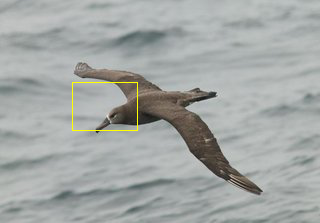

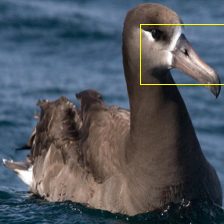

tensor(4.7528) tensor(1)


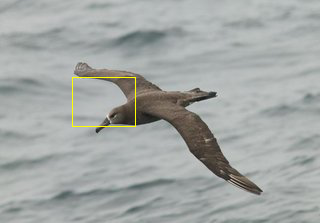

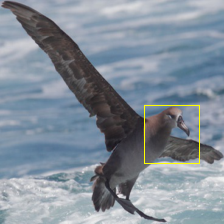

tensor(4.1561) tensor(7)


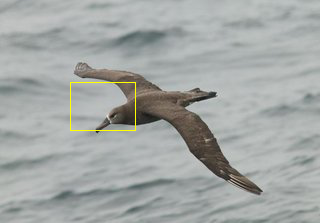

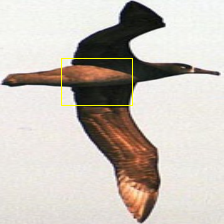

tensor(3.8100) tensor(6)


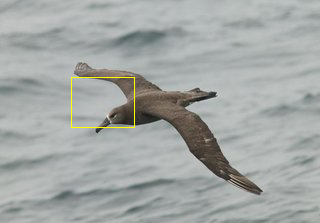

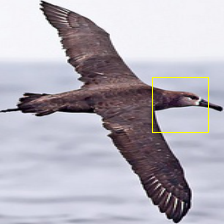

tensor(3.2008) tensor(9)


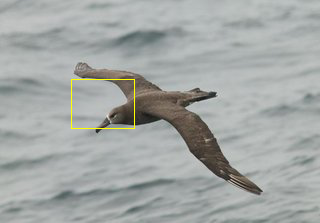

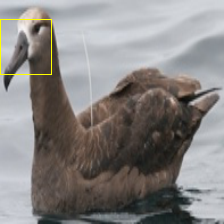

tensor(2.6889) tensor(231)


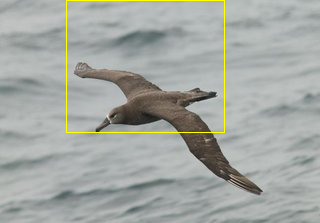

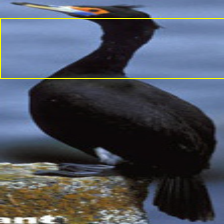

tensor(2.6491) tensor(19)


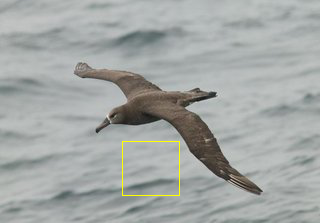

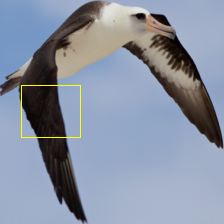

tensor(2.5245) tensor(642)


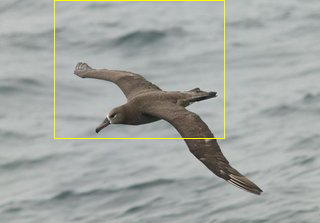

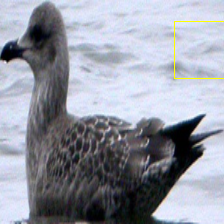

tensor(2.4413) tensor(1425)


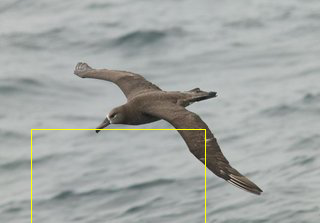

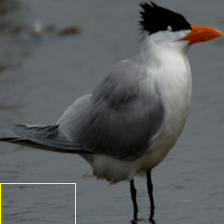

tensor(2.3715) tensor(229)


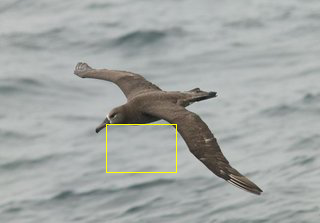

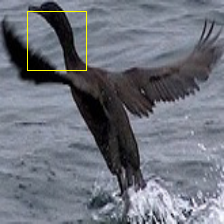

In [9]:
for similarity, index, _ in zip(prototype_similarities[0], prototype_indices[0], range(10)):
    print(similarity, index)
    
    activation = prototype_activations[0, index]
    upsampled_activation = cv2.resize(activation.numpy(), dsize=(model.img_size, model.img_size), interpolation=cv2.INTER_CUBIC)
    ymin, ymax, xmin, xmax = ppnet.helpers.find_high_activation_crop(upsampled_activation)
    annotated = test_image.copy()
    draw = PIL.ImageDraw.Draw(annotated)
    draw.rectangle((xmin, ymin, xmax, ymax), outline=(255, 255, 0))
    display(annotated)
    
    ymin, ymax, xmin, xmax = prototypes[index][1], prototypes[index][2], prototypes[index][3], prototypes[index][4]
    prototype = PIL.Image.open(f"../saved_models/vgg19/006/img/epoch-50/prototype-img-original{index}.png")
    draw = PIL.ImageDraw.Draw(prototype)
    draw.rectangle((xmin, ymin, xmax, ymax), outline=(255, 255, 0))
    display(prototype)
    
#    prototype = PIL.Image.open(f"../saved_models/vgg19/006/img/epoch-50/prototype-img-original{index}.png")
#    display(prototype)
#    prototype = PIL.Image.open(f"../saved_models/vgg19/006/img/epoch-50/prototype-img-original_with_self_act{index}.png")
#    display(prototype)